### Introduction to Time Series Plots

#### Imports

In [27]:
import matplotlib.pyplot as plt
import numpy as np

#### Plot Utilities

In [28]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      label (list of strings)- tag for the line
    """
    plt.figure(figsize=(5,5))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")

    if label:
        plt.legend(fontsize=10, labels=label)
        
    plt.grid(True)
    plt.show()

#### Trend
The **trend** describes the general tendency of the values to go up or down as time progresses. Given a certain time period, you can see if the graph is following an upward/positive trend, downward/negative trend, or just flat. For instance, the housing prices in a good location can see a general increase in valuation as time passes.

In [29]:
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """
    series = slope * time
    return series

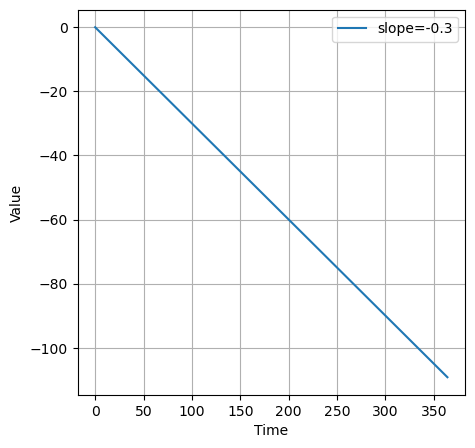

In [30]:
time = np.arange(365)
slope = -0.3
series = trend(time, slope)
plot_series(time, series, label=[f'slope={slope}'])

#### Seasonality
Another attribute you may want to look for is seasonality. This refers to a recurring pattern at regular time intervals. For instance, the hourly temperature might oscillate similarly for 10 consecutive days and you can use that to predict the behavior on the next day.

In [31]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """
    data_pattern = np.where(season_time<0.4, np.cos(season_time*2*np.pi),
                            1/np.exp(3*season_time))
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    season_time = ((time+phase)%period)/period
    data_pattern = amplitude*seasonal_pattern(season_time)
    
    return data_pattern


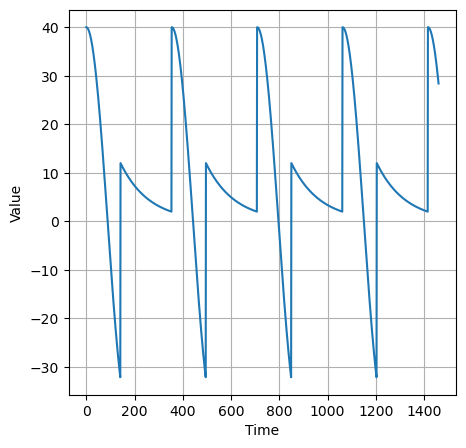

In [32]:
time = np.arange(4*365+1)

period = 354
amplitude = 40

series = seasonality(time, period, amplitude)

plot_series(time, series)

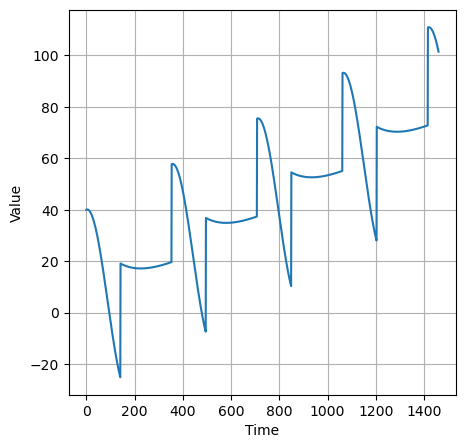

In [33]:
slope = 0.05

series = trend(time, slope) + seasonality(time, period, amplitude)

plot_series(time, series)

#### Noise
In practice, few real-life time series have such a smooth signal. They usually have some noise riding over that signal. The next cells will show what a noisy signal looks like:

In [34]:
def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal

    """
    rnd = np.random.RandomState(seed)

    noise = rnd.randn(len(time)) * noise_level

    return noise

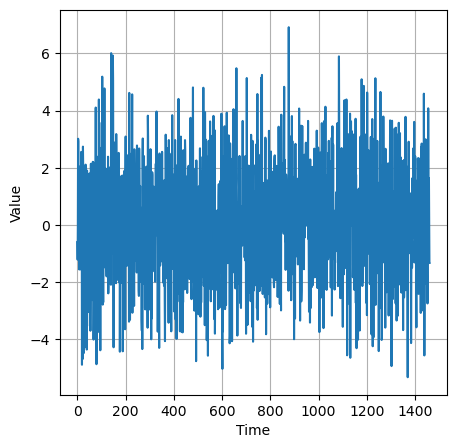

In [36]:
noise_level = 2
noise_signal = noise(time, noise_level, seed=210)
plot_series(time, noise_signal)

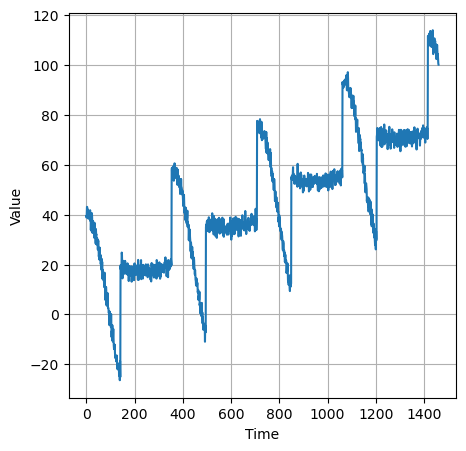

In [37]:
series += noise_signal
plot_series(time, series)

#### Autocorrelation
Time series can also be autocorrelated. This means that measurements at a given time step is a function of previous time steps. Here are some functions that demonstrate that. Notice lines that refer to the `step` variable because this is where the computation from previous time steps happen. It will also include noise (i.e. random numbers) to make the result a bit more realistic.

In [38]:
def autocorrelation(time, amplitude, seed=None):
    """
    Generates autocorrelated data

    Args:
      time (array of int) - contains the time steps
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      ar (array of float) - autocorrelated data
    """
    rnd = np.random.RandomState(seed)
    ar = rnd.randn(len(time)+50)

    ar[:50] = 210 # set first 50 elements to a constant
    
    # define scaling factors
    phi1 = 0.5
    phi2 = -0.1

    # autocorrelate element 51 onwards with the measurement at
    # (t-50) and (t-30), where t is the current time step
    for step in range(50, len(time)+50):
        ar[step] += phi1 * ar[step-50]
        ar[step] += phi2 * ar[step-30]

    # the first 50 elements of the original array is truncated because
    # those are just constant and not autocorrelated
    ar = ar[50:]*amplitude
    
    return ar

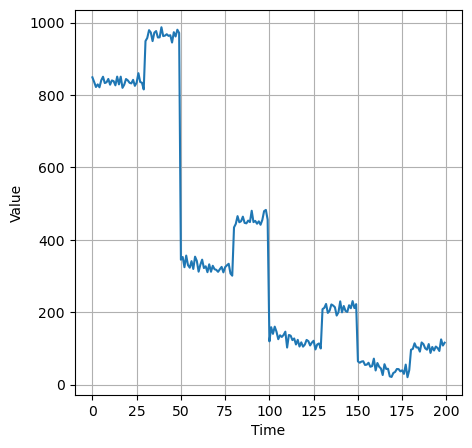

In [39]:
series = autocorrelation(time, amplitude=10, seed=210)

plot_series(time[:200], series[:200])

In [40]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    """
    Generates random impulses

    Args:
      time (array of int) - contains the time steps
      num_impulses (int) - number of impulses to generate
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      series (array of float) - array containing the impulses
    """
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=num_impulses)

    series = np.zeros(len(time))

    for index in impulse_indices:
        series[index] += rnd.rand()*amplitude
    
    return series

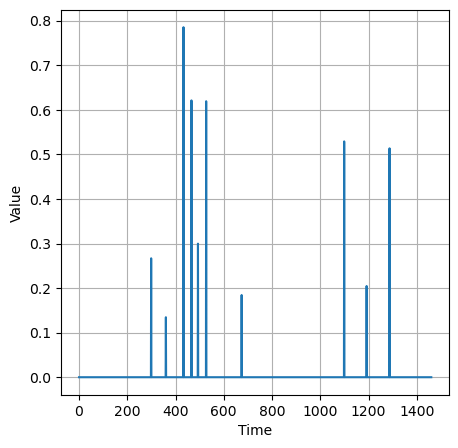

In [41]:
impulses_signal = impulses(time, num_impulses=10, seed=2)
plot_series(time, impulses_signal)

In [42]:
def autocorrelation_impulses(source, phis):
    """
    Generates autocorrelated data from impulses

    Args:
      source (array of float) - contains the time steps with impulses
      phis (dict) - dictionary containing the lag time and decay rates

    Returns:
      ar (array of float) - generated autocorrelated data
    """
    ar = source.copy() # copy the source

    # compute new series values based on the lag times and decay rates
    for step, value in enumerate(source):
        for lag, phi in phis.items():
            if step - lag > 0:
                ar[step] += phi * ar[step-lag]
    
    return ar

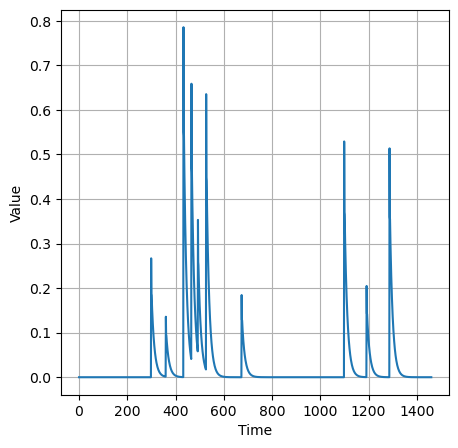

In [48]:
series = autocorrelation_impulses(impulses_signal, {1:0.7, 2:0.2})
plot_series(time, series)

In [50]:
def autocorrelation(time, amplitude, seed=None):
    """
    Generates autocorrelated data

    Args:
      time (array of int) - contains the time steps
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      ar (array of float) - generated autocorrelated data
    """

    # Initialize random number generator 
    rnd = np.random.RandomState(seed)

    # Initialize array of random numbers equal to the length 
    # of the given time steps plus an additional step
    ar = rnd.randn(len(time) + 1)

    # Define scaling factor
    phi = 0.8

    # Autocorrelate element 11 onwards with the measurement at 
    # (t-1), where t is the current time step
    for step in range(1, len(time) + 1):
        ar[step] += phi * ar[step - 1]
    
    # Get the autocorrelated data and scale with the given amplitude.
    ar = ar[1:] * amplitude
    
    return ar

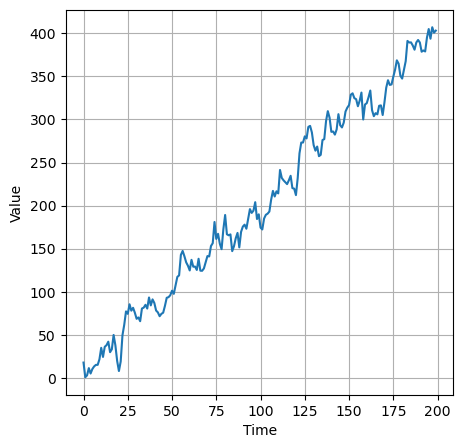

In [51]:
# generate autocorrelated data with an upward trend
series = autocorrelation(time, 10, seed=10) + trend(time, 2)
plot_series(time[:200], series[:200])

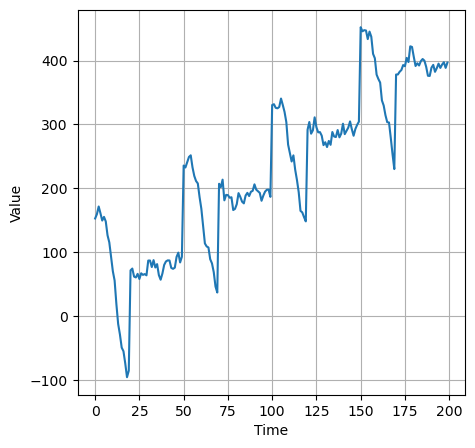

In [52]:
# Generate autocorrelated data with an upward trend
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)

# Plot the results
plot_series(time[:200], series[:200])

#### Non-stationary Time Series
It is also possible for the time series to break an expected pattern. As mentioned in the lectures, big events can alter the trend or seasonal behavior of the data. It would look something like below where the graph shifted to a downward trend at time step = 200.

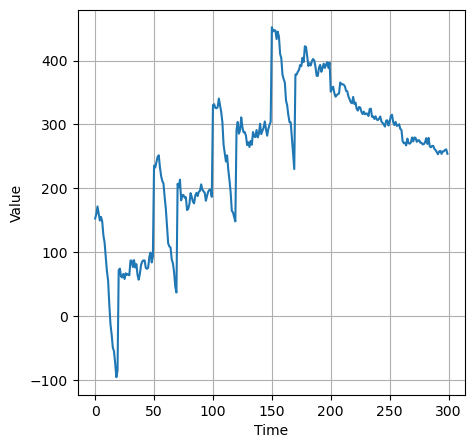

In [53]:
# Generate data with positive trend
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)

# Generate data with negative trend
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550

# Splice the downward trending data into the first one at time step = 200
series[200:] = series2[200:]

# Plot the result
plot_series(time[:300], series[:300])

In cases like this, you may want to train your model on the later steps (i.e. starting at t=200) since these present a stronger predictive signal to future time steps.

#### Wrap up

This concludes this introduction to time series terminologies and attributes. You also saw how to generate them and you will use these to test different forecasting techniques in the next sections. See you there!